In [10]:
# 神经网络的隐层的激活函数可为Relu、softmax、sigmoid等，最后一层根据任务可选softmax、sigmoid等
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import torchvision
from matplotlib import pyplot as plt

In [4]:
def plot_curve(data):
    fig = plt.figure()
    plt.plot(range(len(data)), data, color='blue')
    plt.legend(['value'], loc='upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.show()

def plot_image(img, label, name):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0] * 0.3081 + 0.1307, cmap='gray', interpolation='none')
        plt.title('{}: {}'.format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

def one_hot(label, depth=10):
    out = torch.zeros(label.size(0), depth)
    idx = torch.LongTensor(label).view(-1, 1)
    out.scatter_(dim=1, index=idx, value=1)
    return out

In [6]:
batch_size = 512

# step1: load dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data', train=True, download=True, 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                               ])), batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data/', train=False, download=True, 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                               ])), batch_size=batch_size, shuffle=True)

100.0%


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100.0%


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100.0%


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100.0%

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



torch.Size([512, 1, 28, 28]) torch.Size([512])


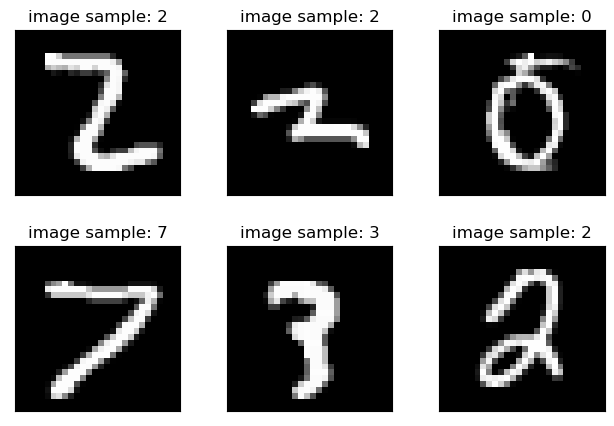

In [8]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
plot_image(x, y, 'image sample')

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x ):
        # x: [b, 1, 28, 28]
        # h1 = relu(x*w1 + b1)
        x = F.relu(self.fc1(x))
        
        # h2 = relu(h1 * w2 + b2)
        x = F.relu(self.fc2(x))
        
        # h3 = relu(h3 * w3 + b3)
        x = self.fc3(x)
        
        return x

epoch: 0, batch_idx: 0, loss: 0.10774364322423935

epoch: 0, batch_idx: 100, loss: 0.05446336418390274

epoch: 1, batch_idx: 0, loss: 0.05146734043955803

epoch: 1, batch_idx: 100, loss: 0.038826920092105865

epoch: 2, batch_idx: 0, loss: 0.035228386521339417

epoch: 2, batch_idx: 100, loss: 0.0344107523560524



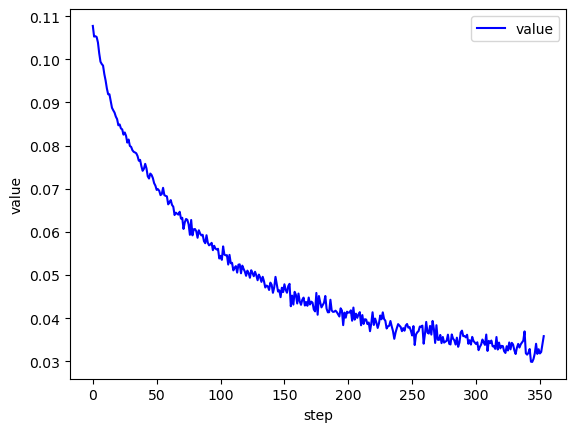

In [13]:
net = Net()

# net.parameters()指出优化的参数 [w1, b1, w2, b2, w3, b3]
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

train_loss = []  # loss 衡量或者说是指导训练的指标

for epoch in range(3):
    for batch_idx, (x, y) in enumerate(train_loader):
        
        # 数据形状 x: [b, 1, 28, 28], y: [512]
        # 对数据做预处理 [b, 1, 28, 28] => [b , 784]
        x = x.view(x.size(0), 28 *28)
        
        # 网络运算，输出数据维度为[b, 10]
        out = net(x)
        
        # 对label做编码
        y_onehot = one_hot(y)
        
        # 计算loss = mse(out, y_onehot)
        loss = F.mse_loss(out, y_onehot)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        # w' = w - lr * grad
        optimizer.step()
        
        train_loss.append(loss.item())
        
        if batch_idx % 100 == 0:
            print('epoch: {}, batch_idx: {}, loss: {}\n'.format(epoch, batch_idx, loss.item()))

plot_curve(train_loss)

# we get optimal [w1, b1, w2, b2, w3, b3]

In [14]:
total_correct = 0
for x, y in test_loader:
    x = x.view(x.size(0), 28 * 28)
    out = net(x)
    # out: [b, 10] => pred: [b]
    pred = out.argmax(dim=1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct
    
total_num = len(test_loader.dataset)
acc = total_correct / total_num
print(acc)

0.8875


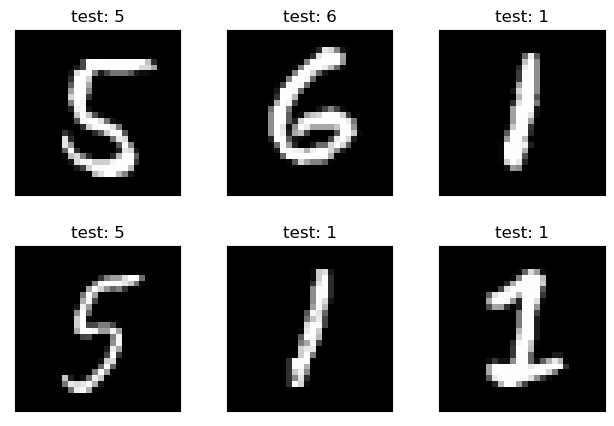

In [15]:
x, y = next(iter(test_loader))
out = net(x.view(x.size(0), 28 * 28))
pred = out.argmax(dim=1)
plot_image(x, pred, 'test')

In [16]:
torch.save(net.state_dict(), './3-epoch.pth')

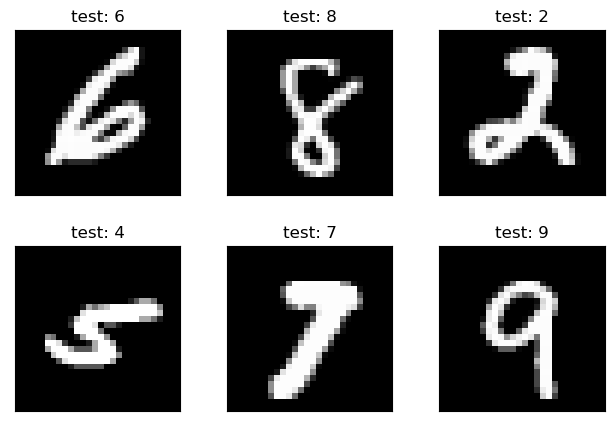

In [21]:
net1 = Net()
net1.load_state_dict(torch.load('./3-epoch.pth'))

x, y = next(iter(test_loader))
out = net1(x.view(x.size(0), 28 * 28))
pred = out.argmax(dim=1)
plot_image(x, pred, 'test')